In [ ]:
# ==========================================================
#  ABSA SECURITY SENTIMENT ANALYSIS - DATA SAMPLING FOR ANNOTATION
#  Step for Reviewer Revision: Manual Annotation Validation
# ==========================================================

# Import library
import pandas as pd

In [ ]:
# Baca dataset yang sudah diupload ke Colab
df = pd.read_csv("/content/data_sentimen_keamanan.csv")

In [ ]:
# Cek distribusi label sentimen
print("\n=== Distribusi Label Sentimen ===")
print(df['sentimen'].value_counts())


=== Distribusi Label Sentimen ===
sentimen
negatif    3602
positif    1244
Name: count, dtype: int64


In [ ]:
# Ambil 300 data proporsional antar kelas (150 positif, 150 negatif)
# Pastikan nama label sesuai ('positif' dan 'negatif')
n_per_class = 150

df_pos = df[df['sentimen'].str.lower() == 'positif'].sample(n=n_per_class, random_state=42)
df_neg = df[df['sentimen'].str.lower() == 'negatif'].sample(n=n_per_class, random_state=42)

# Gabungkan dan acak
df_sample = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\n=== Jumlah Data Terpilih per Kelas ===")
print(df_sample['sentimen'].value_counts())


=== Jumlah Data Terpilih per Kelas ===
sentimen
negatif    150
positif    150
Name: count, dtype: int64


In [ ]:
# Buat dua versi file hasil

# Versi untuk ANOTATOR (tanpa kolom score & sentimen)
df_annotator = df_sample[['reviewId', 'content']].copy()
df_annotator['annotator_1'] = ""
df_annotator['annotator_2'] = ""

# Versi untuk PENELITI (lengkap, menyimpan kolom label)
df_full = df_sample.copy()
df_full['annotator_1'] = ""
df_full['annotator_2'] = ""

In [ ]:
# Simpan file hasil
annotator_path = "/content/annotations_for_annotators.csv"
researcher_path = "/content/annotations_full_for_researcher.csv"

df_annotator.to_csv(annotator_path, index=False)
df_full.to_csv(researcher_path, index=False)

print("\n✅ File berhasil dibuat:")
print(f"- Untuk anotator: {annotator_path}")
print(f"- Untuk peneliti: {researcher_path}")


✅ File berhasil dibuat:
- Untuk anotator: /content/annotations_for_annotators.csv
- Untuk peneliti: /content/annotations_full_for_researcher.csv


In [ ]:
# Preview beberapa data untuk verifikasi
print("\n=== Contoh Data untuk Anotator ===")
print(df_annotator.head(10))


=== Contoh Data untuk Anotator ===
                               reviewId  \
0  70c0b377-3eb9-4ed2-ad6f-bca8d70d4d4d   
1  3d2ece05-38d7-4295-b79d-3cf7a84a20d7   
2  eda35517-462e-4b27-a8b4-ae76dc91ad20   
3  519646d1-93f3-4173-a7de-8a091dda41e0   
4  7188f50c-c8f9-4ab1-ad11-f9b8c2efba11   
5  1d460300-6215-403c-8089-4a6883bd2360   
6  e02264cd-5367-4baa-aa9c-c53f09ef0f21   
7  fad821fa-398b-439e-b74a-cd858f5c6768   
8  a50b4715-5890-4809-bc88-94f7230ba94f   
9  9a490483-210a-4722-90cf-f96c623da2fb   

                                             content annotator_1 annotator_2  
0  Makin Buruk Saja DANA Masa Mau Login For Close...                          
1  keamanan yg buruk uang saya ilang tiba2 katany...                          
2              dana saya bermasalah tidak bisa login                          
3  otp jangan d batasi di karenakan ada keperluan...                          
4  sangat memudah buat melakukan transaksi, apa l...                          
5  saldo saya te

In [ ]:
# ==========================================================
#  Evaluasi Kualitas Anotasi Manual
#  Menghitung Inter-Annotator Agreement (Cohen’s Kappa)
# ==========================================================

import pandas as pd
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load file hasil anotasi
df = pd.read_csv("/content/hasil_annotations_for_annotators.csv")

In [ ]:
# Buang baris yang kosong atau ambigu
df_filtered = df[(df['annotator_1'].notna()) & (df['annotator_2'].notna())]
df_filtered = df_filtered[
    (df_filtered['annotator_1'].str.lower() != "ambigu") &
    (df_filtered['annotator_2'].str.lower() != "ambigu")
].copy()

print(f"Total data sebelum: {len(df)}")
print(f"Total data sesudah filter: {len(df_filtered)}\n")

Total data sebelum: 300
Total data sesudah filter: 248



In [ ]:
# Hitung Cohen's Kappa
kappa = cohen_kappa_score(df_filtered['annotator_1'].str.lower(), df_filtered['annotator_2'].str.lower())
print(f"✅ Cohen’s Kappa: {kappa:.3f}")


✅ Cohen’s Kappa: 0.951


In [ ]:
# Persentase kesepakatan sederhana
agreement = (df_filtered['annotator_1'].str.lower() == df_filtered['annotator_2'].str.lower()).mean()
print(f"📊 Raw Agreement: {agreement*100:.2f}%")


📊 Raw Agreement: 97.58%


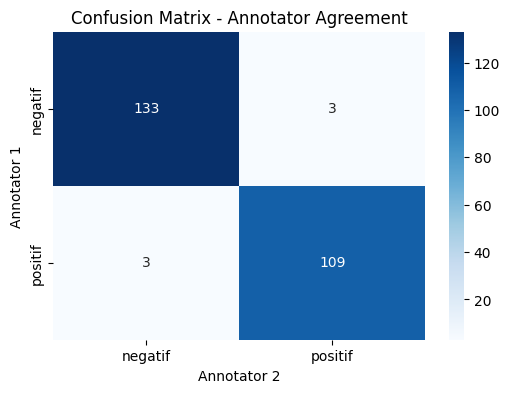

In [ ]:
# Confusion matrix antar anotator
labels = sorted(df_filtered['annotator_1'].str.lower().unique())
cm = confusion_matrix(df_filtered['annotator_1'].str.lower(), df_filtered['annotator_2'].str.lower(), labels=labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Annotator 2")
plt.ylabel("Annotator 1")
plt.title("Confusion Matrix - Annotator Agreement")
plt.show()

In [ ]:
# ==========================================================
#  Membuat Label Final (Consensus) dari Dua Annotator
# ==========================================================
import pandas as pd

In [ ]:
# Baca file hasil anotasi
df = pd.read_csv("/content/hasil_annotations_for_annotators.csv")

In [ ]:
# Normalisasi huruf kecil biar konsisten
df['annotator_1'] = df['annotator_1'].str.lower().str.strip()
df['annotator_2'] = df['annotator_2'].str.lower().str.strip()

In [ ]:
# Buat kolom label_final berdasarkan kesepakatan
def consensus(row):
    if row['annotator_1'] == row['annotator_2']:
        return row['annotator_1']
    else:
        return "review"

df['label_final'] = df.apply(consensus, axis=1)

In [ ]:
# Cek distribusi hasil
print("Distribusi label final:")
print(df['label_final'].value_counts())

Distribusi label final:
label_final
negatif    133
positif    109
ambigu      42
review      16
Name: count, dtype: int64


In [ ]:
# Simpan hasil
output_path = "/content/hasil_label_final.csv"
df.to_csv(output_path, index=False)
print(f"\n✅ File hasil kesepakatan anotator disimpan di: {output_path}")


✅ File hasil kesepakatan anotator disimpan di: /content/hasil_label_final.csv


In [ ]:
# Tampilkan contoh hasil
df.head(10)

,reviewId,content,annotator_1,annotator_2,label_final
0,70c0b377-3eb9-4ed2-ad6f-bca8d70d4d4d,Makin Buruk Saja DANA Masa Mau Login For Close...,negatif,negatif,negatif
1,3d2ece05-38d7-4295-b79d-3cf7a84a20d7,keamanan yg buruk uang saya ilang tiba2 katany...,negatif,negatif,negatif
2,eda35517-462e-4b27-a8b4-ae76dc91ad20,dana saya bermasalah tidak bisa login,negatif,negatif,negatif
3,519646d1-93f3-4173-a7de-8a091dda41e0,otp jangan d batasi di karenakan ada keperluan...,ambigu,positif,review
4,7188f50c-c8f9-4ab1-ad11-f9b8c2efba11,"sangat memudah buat melakukan transaksi, apa l...",positif,positif,positif
5,1d460300-6215-403c-8089-4a6883bd2360,saldo saya tersedot 35.000 transaksi pembayara...,negatif,negatif,negatif
6,e02264cd-5367-4baa-aa9c-c53f09ef0f21,SARANNNNN!!!!! YANG MAU DONLOT DANA MENDING PI...,negatif,negatif,negatif
7,fad821fa-398b-439e-b74a-cd858f5c6768,tingkat kan keamanan,negatif,negatif,negatif
8,a50b4715-5890-4809-bc88-94f7230ba94f,tingkatkan kualitas keamanan akun,negatif,negatif,negatif
9,9a490483-210a-4722-90cf-f96c623da2fb,FITUR DANA SEKARANG MENGECEWAKAN BUAT APLIKASI...,ambigu,ambigu,ambigu


In [ ]:
# ==========================================================
#  Evaluasi Label Otomatis (Rule-Based) vs Label Manual Final
# ==========================================================

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Baca dataset asli (yang berisi kolom `sentimen` rule-based)
df_rule = pd.read_csv("/content/data_sentimen_keamanan.csv")

# Baca hasil anotasi final yang sudah direview manual
df_manual = pd.read_csv("/content/hasil_label_final_review.csv")

In [ ]:
# Gabungkan berdasarkan reviewId
df_merged = pd.merge(df_manual, df_rule[['reviewId', 'sentimen']], on='reviewId', how='inner')

In [ ]:
# Normalisasi teks label biar konsisten
df_merged['label_final'] = df_merged['label_final'].str.lower().str.strip()
df_merged['sentimen'] = df_merged['sentimen'].str.lower().str.strip()

In [ ]:
# Filter hanya data dengan label_final valid (positif/negatif)
df_valid = df_merged[df_merged['label_final'].isin(['positif', 'negatif'])].copy()

print(f"Total data valid untuk evaluasi: {len(df_valid)}")

Total data valid untuk evaluasi: 254


In [ ]:
# Hitung metrik evaluasi
y_true = df_valid['label_final']
y_pred = df_valid['sentimen']

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, pos_label='positif')
rec = recall_score(y_true, y_pred, pos_label='positif')
f1 = f1_score(y_true, y_pred, pos_label='positif')

print("\n=== 📊 Hasil Evaluasi Rule-Based Labeling ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")


=== 📊 Hasil Evaluasi Rule-Based Labeling ===
Accuracy  : 0.8504
Precision : 0.8080
Recall    : 0.8783
F1-Score  : 0.8417


In [ ]:
# Laporan klasifikasi lengkap
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, digits=4))


=== Classification Report ===
              precision    recall  f1-score   support

     negatif     0.8915    0.8273    0.8582       139
     positif     0.8080    0.8783    0.8417       115

    accuracy                         0.8504       254
   macro avg     0.8497    0.8528    0.8499       254
weighted avg     0.8537    0.8504    0.8507       254



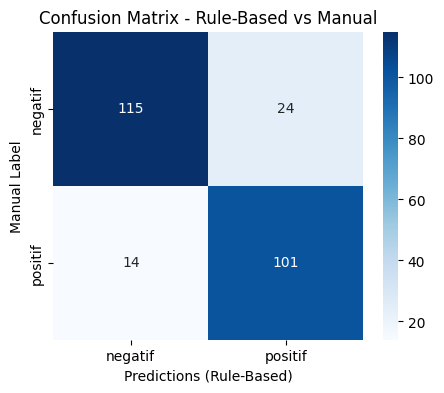

In [ ]:
# Confusion Matrix visual
cm = confusion_matrix(y_true, y_pred, labels=['negatif', 'positif'])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negatif', 'positif'], yticklabels=['negatif', 'positif'])
plt.xlabel("Predictions (Rule-Based)")
plt.ylabel("Manual Label")
plt.title("Confusion Matrix - Rule-Based vs Manual")
plt.show()


In [ ]:
# Simpan hasil gabungan untuk dokumentasi
output_path = "/content/evaluasi_rule_based_vs_manual.csv"
df_valid.to_csv(output_path, index=False)
print(f"\n✅ File hasil evaluasi disimpan di: {output_path}")


✅ File hasil evaluasi disimpan di: /content/evaluasi_rule_based_vs_manual.csv
